##### <b>Step-1: Importing Libraries</b>

In [ ]:
import os                               
import cv2
import time                              
import numpy as np   
import tensorflow as tf 
from PIL import Image
import numpy as np

import tensorflow as tf
from tensorflow import keras
from skimage import transform
from google.colab import drive 
from keras import backend as K           
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from keras.models import load_model
from keras.preprocessing import image  
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,Conv2DTranspose,MaxPool2D,Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##### <b>Step-2: Mounting Drive</b>

In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
path="/content/drive/MyDrive/UnetData/Viral Pneumonia"

In [ ]:
os.listdir(path)

['images', 'masks']

In [ ]:
images_path=os.path.join(path,'images')
mask_path=os.path.join(path,'masks')

In [ ]:
train_ids = next(os.walk(images_path))[1]

In [ ]:
import glob

In [ ]:
def read_data(images_path,masks_path):
  images=[]
  masks=[]
  i=0
  for subdir, dirs, files in os.walk(images_path):
    for file in files:
      name=os.path.splitext(file)[0]
      image = cv2.imread(os.path.join(images_path, file)) 
      mask = cv2.imread(os.path.join(masks_path, file)) 
      image=cv2.resize(image,(128,128), interpolation = cv2.INTER_AREA)
      mask=cv2.resize(mask,(128,128), interpolation = cv2.INTER_AREA)
      mask =cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
      mask=np.expand_dims(mask, axis=-1)
      print('Image Dimensions : ',image.shape)
      print('mask Dimensions : ',mask.shape)
      image = image/255.0
      mask = mask/255.0
      print(i)
      i=i+1
      images.append(image)
      masks.append(mask)  
  images=np.array(images)
  masks=np.array(masks)
  return images, masks
       

In [ ]:
images,masks=read_data(images_path,mask_path)

Image Dimensions :  (128, 128, 3)
mask Dimensions :  (128, 128, 1)
0
Image Dimensions :  (128, 128, 3)
mask Dimensions :  (128, 128, 1)
1
Image Dimensions :  (128, 128, 3)
mask Dimensions :  (128, 128, 1)
2
Image Dimensions :  (128, 128, 3)
mask Dimensions :  (128, 128, 1)
3
Image Dimensions :  (128, 128, 3)
mask Dimensions :  (128, 128, 1)
4
Image Dimensions :  (128, 128, 3)
mask Dimensions :  (128, 128, 1)
5
Image Dimensions :  (128, 128, 3)
mask Dimensions :  (128, 128, 1)
6
Image Dimensions :  (128, 128, 3)
mask Dimensions :  (128, 128, 1)
7
Image Dimensions :  (128, 128, 3)
mask Dimensions :  (128, 128, 1)
8
Image Dimensions :  (128, 128, 3)
mask Dimensions :  (128, 128, 1)
9
Image Dimensions :  (128, 128, 3)
mask Dimensions :  (128, 128, 1)
10
Image Dimensions :  (128, 128, 3)
mask Dimensions :  (128, 128, 1)
11
Image Dimensions :  (128, 128, 3)
mask Dimensions :  (128, 128, 1)
12
Image Dimensions :  (128, 128, 3)
mask Dimensions :  (128, 128, 1)
13
Image Dimensions :  (128, 128,

In [ ]:
image_size=128

# Unet Model

## Encoder and Decoder

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

# Model Compilation

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
history = model.fit(images,masks,
                          batch_size=16,epochs=3,verbose = 1,
                          )

Epoch 1/3
85/85 [==============================] - 196s 2s/step - loss: 0.1582 - acc: 0.9246
Epoch 2/3
85/85 [==============================] - 200s 2s/step - loss: 0.0810 - acc: 0.9579
Epoch 3/3
85/85 [==============================] - 198s 2s/step - loss: 0.0633 - acc: 0.9649


In [ ]:
result = model.predict(images[0:10])


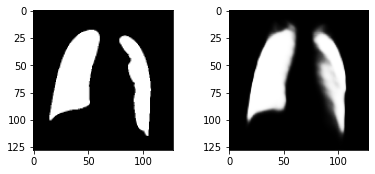

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(masks[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")